In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import glob
import os
import matplotlib.pyplot as plt

# Define dataset folder
dataset_path = "/content/gdrive/My Drive/data-ex2/data/train/"

shoe_pairs = {}

for file in glob.glob(dataset_path + "*.jpg"):
    filename = os.path.basename(file)

    identifier = "_".join(filename.split("_")[:2])

    if identifier not in shoe_pairs:
        shoe_pairs[identifier] = {"left": None, "right": None}

    if "left" in filename:
        shoe_pairs[identifier]["left"] = file
    elif "right" in filename:
        shoe_pairs[identifier]["right"] = file

# Print first few pairs to verify
for key, value in list(shoe_pairs.items())[:5]:
    print(f"Pair {key}: Left Shoe - {value['left']}, Right Shoe - {value['right']}")

Pair u001_1: Left Shoe - /content/gdrive/My Drive/data-ex2/data/train/u001_1_left_w.jpg, Right Shoe - /content/gdrive/My Drive/data-ex2/data/train/u001_1_right_w.jpg
Pair u004_3: Left Shoe - /content/gdrive/My Drive/data-ex2/data/train/u004_3_left_w.jpg, Right Shoe - /content/gdrive/My Drive/data-ex2/data/train/u004_3_right_w.jpg
Pair u007_3: Left Shoe - /content/gdrive/My Drive/data-ex2/data/train/u007_3_left_w.jpg, Right Shoe - /content/gdrive/My Drive/data-ex2/data/train/u007_3_right_w.jpg
Pair u009_1: Left Shoe - /content/gdrive/My Drive/data-ex2/data/train/u009_1_left_m.jpg, Right Shoe - /content/gdrive/My Drive/data-ex2/data/train/u009_1_right_m.jpg
Pair u010_1: Left Shoe - /content/gdrive/My Drive/data-ex2/data/train/u010_1_left_m.jpg, Right Shoe - /content/gdrive/My Drive/data-ex2/data/train/u010_1_right_m.jpg


In [4]:
complete_pairs = {k: v for k, v in shoe_pairs.items() if v['left'] and v['right']}
print(f"Total valid pairs: {len(complete_pairs)}")

Total valid pairs: 336


In [5]:
from PIL import Image

def load_and_resize(image_path, size=(224, 224)):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(size)
    return np.array(img)

In [6]:
def generate_same_pair(pairs_dict):
    same_pairs = []
    for key, pair in pairs_dict.items():
        left_img = load_and_resize(pair['left'])
        right_img = load_and_resize(pair['right'])
        stacked = np.vstack((left_img, right_img))
        same_pairs.append(stacked)
    return np.array(same_pairs)

In [7]:
def generate_different_pair(pairs_dict):
    keys = list(pairs_dict.keys())
    np.random.shuffle(keys)

    different_pairs = []
    for i in range(len(keys)):
        key1 = keys[i]
        key2 = keys[(i + 1) % len(keys)]  # rotate index for pairing

        left_img = load_and_resize(pairs_dict[key1]['left'])
        right_img = load_and_resize(pairs_dict[key2]['right'])
        stacked = np.vstack((left_img, right_img))
        different_pairs.append(stacked)
    return np.array(different_pairs)

Text(0.5, 1.0, 'Different Pair')

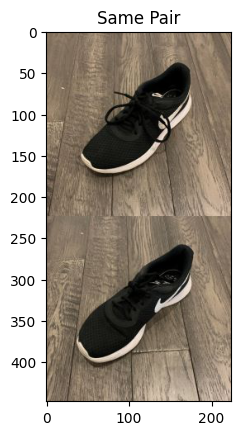

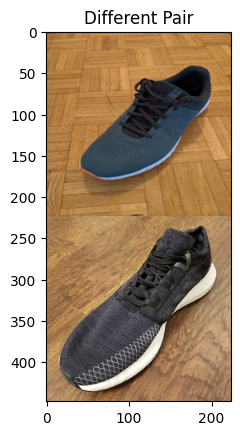

In [8]:
same_data = generate_same_pair(complete_pairs)
diff_data = generate_different_pair(complete_pairs)

plt.figure()
plt.imshow(same_data[0])
plt.title("Same Pair")

plt.figure()
plt.imshow(diff_data[0])
plt.title("Different Pair")

In [9]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class ShoePairDataset(Dataset):
    def __init__(self, images, label):
        self.images = images
        self.labels = label
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.transform(self.images[idx])
        lbl = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, lbl

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 56 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [11]:
def train_model(model, train_loader, epochs=25, lr=0.0005, batch_size=64, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels) + 0.1 * torch.abs(outputs[:, 0] - outputs[:, 1]).mean()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        scheduler.step()  # Adjust learning rate dynamically
        acc = correct / total * 100
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {acc:.2f}%")

    print("Training complete")
    return model

In [12]:
#same_data = generate_same_pair(complete_pairs)
#diff_data = generate_different_pair(complete_pairs)

X = np.concatenate((same_data, diff_data), axis=0)
y = np.array([1]*len(same_data) + [0]*len(diff_data))

indices = np.random.permutation(len(X))
X, y = X[indices], y[indices]

train_dataset = ShoePairDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [13]:
#model = CNN()
#trained_model = fine_tune_model(model, train_loader, epochs=25)

In [14]:
#torch.save(trained_model.state_dict(), "/content/gdrive/My Drive/cnn_model.pth")

In [15]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # **New extra layer**
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 28 * 14, 1024),  # Increased neurons
            nn.ReLU(),
            nn.Dropout(0.2),  # Lower dropout to preserve learning
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [16]:
#cnn_channel_model = CNNChannel()
#trained_cnn_channel = train_model(cnn_channel_model, train_loader, epochs=25)

In [17]:
#torch.save(trained_cnn_channel.state_dict(), "/content/gdrive/My Drive/cnn_channel_model.pth")

In [18]:
import os
print(os.listdir("/content/gdrive/My Drive/"))  # Lists saved files in Drive

['WoWScrnShot_070313_191900.jpg', 'Untitled document (3).gdoc', 'mail-1726599-2781581.zip', 'mail-1730036-2782109.zip', 'Untitled spreadsheet (3).gsheet', 'mail-1768475-2813409.java', 'mail-1808487-2833544.zip', 'Untitled document (2).gdoc', 'mtg pdf decks', 'CV.gdoc', 'Afeka Zoom.gdoc', 'Untitled spreadsheet (2).gsheet', 'Untitled spreadsheet (1).gsheet', 'תו ירוק.pdf', 'GreenPass.pdf', 'Algebra 2 402 Lectures.pdf', 'Algebra 2 401.pdf', 'מערכת שעות.gsheet', '40346441.gif', 'Colab Notebooks', 'Adobe Scan 17 Jan 2024.pdf', 'Untitled document (1).gdoc', 'flexExplain_2.doc', 'מילה.docx', 'Untitled spreadsheet.gsheet', 'Untitled document.gdoc', 'No need, what i would like you to do is to genera....gsheet', 'Untitled Diagram.drawio', 'ARCIS sequence diagram.drawio', 'ARCIS class diagram (2).drawio', 'ARCIS class diagram (1).drawio', 'ARCIS class diagram.drawio.pdf', 'ARCIS class diagram.drawio', 'buy stuff.gsheet', 'data-ex2', 'cnn_model.pth', 'cnn_channel_model.pth', 'training_results.pt',

In [19]:
cnn_model = CNN()
cnn_model.load_state_dict(torch.load("/content/gdrive/My Drive/cnn_model.pth"))
cnn_model.eval()

cnn_channel_model = CNNChannel()
cnn_channel_model.load_state_dict(torch.load("/content/gdrive/My Drive/cnn_channel_model.pth"))
cnn_channel_model.eval()

CNNChannel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [20]:
import os
import glob
import numpy as np

valid_path_w = "/content/gdrive/My Drive/data-ex2/data/test_w/"
valid_path_m = "/content/gdrive/My Drive/data-ex2/data/test_m/"

valid_pairs = {}

for file in glob.glob(valid_path_w + "*.jpg") + glob.glob(valid_path_m + "*.jpg"):
    filename = os.path.basename(file)
    identifier = "_".join(filename.split("_")[:2])

    if identifier not in valid_pairs:
        valid_pairs[identifier] = {"left": None, "right": None}

    if "left" in filename:
        valid_pairs[identifier]["left"] = file
    elif "right" in filename:
        valid_pairs[identifier]["right"] = file

valid_data = {k: v for k, v in valid_pairs.items() if v["left"] and v["right"]}

print(f"Total validation pairs: {len(valid_data)}")

Total validation pairs: 60


In [21]:
import cv2

def load_and_resize(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return img

In [22]:
def generate_same_pair(pairs_dict):
    same_pairs = []
    for key, pair in pairs_dict.items():
        left_img = load_and_resize(pair['left'])
        right_img = load_and_resize(pair['right'])
        same_pairs.append(np.stack([left_img, right_img], axis=0))
    return np.array(same_pairs)

def generate_different_pair(pairs_dict):
    different_pairs = []
    keys = list(pairs_dict.keys())

    for i in range(len(keys) - 1):
        left_img = load_and_resize(pairs_dict[keys[i]]['left'])
        right_img = load_and_resize(pairs_dict[keys[i + 1]]['right'])
        different_pairs.append(np.stack([left_img, right_img], axis=0))
    return np.array(different_pairs)

In [23]:
# Properly stack image pairs vertically to match training format
valid_same_data = np.array([np.vstack([load_and_resize(pair['left']), load_and_resize(pair['right'])]) for pair in valid_data.values()])

keys = list(valid_data.keys())  # Define keys before using them

valid_diff_data = np.array([np.vstack([load_and_resize(valid_data[keys[i]]['left']), load_and_resize(valid_data[keys[i+1]]['right'])]) for i in range(len(keys) - 1)])

# Combine validation pairs and labels
valid_X = np.concatenate((valid_same_data, valid_diff_data), axis=0)
valid_y = np.array([1] * len(valid_same_data) + [0] * len(valid_diff_data))

# Shuffle validation data
indices = np.random.permutation(len(valid_X))
valid_X, valid_y = valid_X[indices], valid_y[indices]

# Convert to tensor with correct shape
valid_X_tensor = torch.Tensor(valid_X).unsqueeze(1)  # Adds a channel dimension if needed

In [24]:
def get_accuracy(model, data, labels, batch_size=50):
    """Compute the model accuracy on the dataset.
    Returns positive accuracy (same pairs) and negative accuracy (different pairs)."""

    model.eval()
    labels_tensor = torch.tensor(labels)

    # Ensure data has correct shape & channels
    data_pos = data[labels_tensor == 1].squeeze(1).permute(0, 3, 1, 2)  # Fix extra dimension
    data_neg = data[labels_tensor == 0].squeeze(1).permute(0, 3, 1, 2)

    # Debugging: Print Shapes
    print(f"Shape of data_pos: {data_pos.shape}")  # Expected: [batch_size, 3, 224, 224]
    print(f"Shape of data_neg: {data_neg.shape}")  # Expected: [batch_size, 3, 224, 224]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = data_pos[i:i+batch_size]
        zs = model(xs)
        pred = zs.argmax(dim=1)
        pos_correct += (pred == 1).sum().item()

    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = data_neg[i:i+batch_size]
        zs = model(xs)
        pred = zs.argmax(dim=1)
        neg_correct += (pred == 0).sum().item()

    return pos_correct / len(data_pos), neg_correct / len(data_neg)  # Normalize correctly

In [25]:
pos_acc_cnn, neg_acc_cnn = get_accuracy(cnn_model, valid_X_tensor, valid_y)
print(f"Updated CNN Accuracy → Positive: {pos_acc_cnn:.2f}, Negative: {neg_acc_cnn:.2f}")

pos_acc_channel, neg_acc_channel = get_accuracy(cnn_channel_model, valid_X_tensor, valid_y)
print(f"Updated CNNChannel Accuracy → Positive: {pos_acc_channel:.2f}, Negative: {neg_acc_channel:.2f}")

Shape of data_pos: torch.Size([60, 3, 448, 224])
Shape of data_neg: torch.Size([59, 3, 448, 224])
Updated CNN Accuracy → Positive: 1.00, Negative: 0.56
Shape of data_pos: torch.Size([60, 3, 448, 224])
Shape of data_neg: torch.Size([59, 3, 448, 224])
Updated CNNChannel Accuracy → Positive: 1.00, Negative: 0.44


In [26]:
print(f"Sample Validation Data Shape: {valid_X.shape}")
print(f"First 5 Labels: {valid_y[:5]}")

Sample Validation Data Shape: (119, 448, 224, 3)
First 5 Labels: [0 1 0 1 0]


In [27]:
import torch

# Load training data from Google Drive
training_data = torch.load("/content/gdrive/My Drive/training_results.pt")

# Extract stored values
cnn_losses = training_data["cnn_losses"]
cnn_accuracies = training_data["cnn_accuracies"]
cnn_channel_losses = training_data["cnn_channel_losses"]
cnn_channel_accuracies = training_data["cnn_channel_accuracies"]

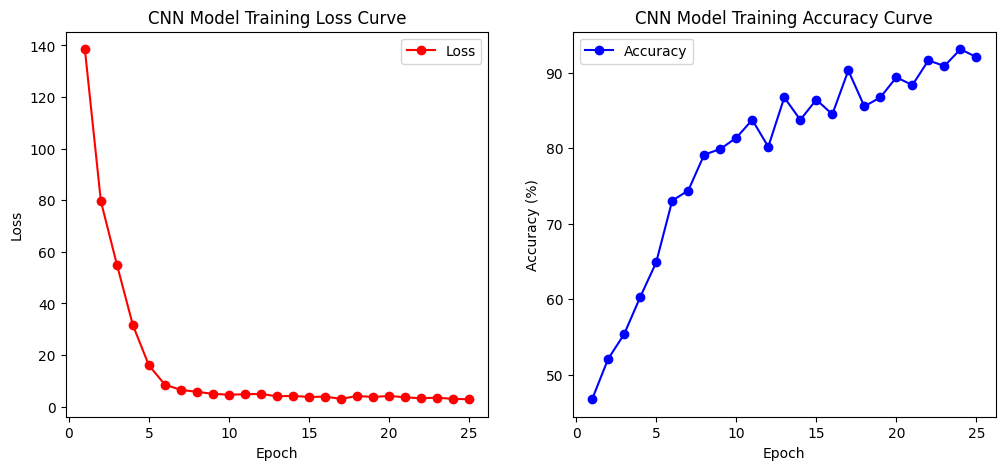

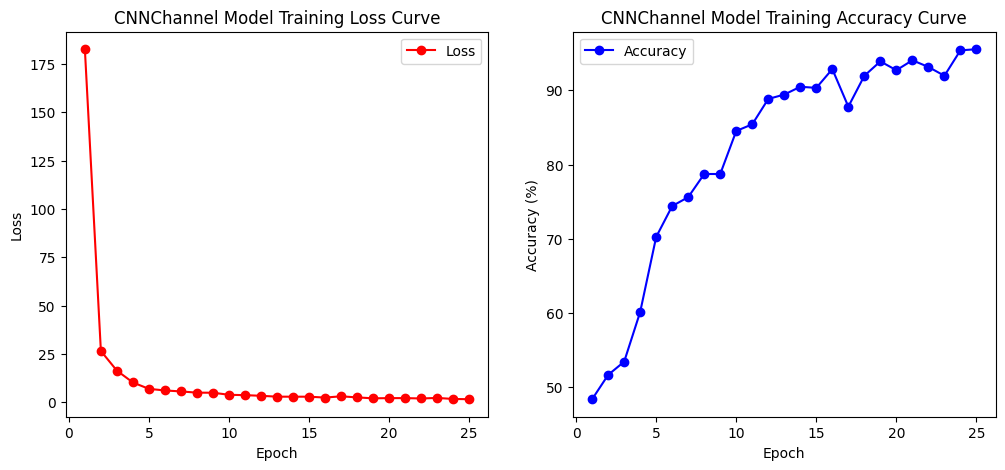

In [28]:
import matplotlib.pyplot as plt

def plot_training_curves(losses, accuracies, model_name):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label="Loss", color="red", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Training Loss Curve")
    plt.legend()

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label="Accuracy", color="blue", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{model_name} Training Accuracy Curve")
    plt.legend()

    plt.show()

# Plot CNN Model Training Curve
plot_training_curves(cnn_losses, cnn_accuracies, "CNN Model")

# Plot CNNChannel Model Training Curve
plot_training_curves(cnn_channel_losses, cnn_channel_accuracies, "CNNChannel Model")

In [29]:
print(f"Final Model Accuracy:")
print(f"CNN Model → Positive Accuracy: {pos_acc_cnn:.2f}%")
print(f"CNNChannel Model → Positive Accuracy: {pos_acc_channel:.2f}%")

Final Model Accuracy:
CNN Model → Positive Accuracy: 1.00%
CNNChannel Model → Positive Accuracy: 1.00%


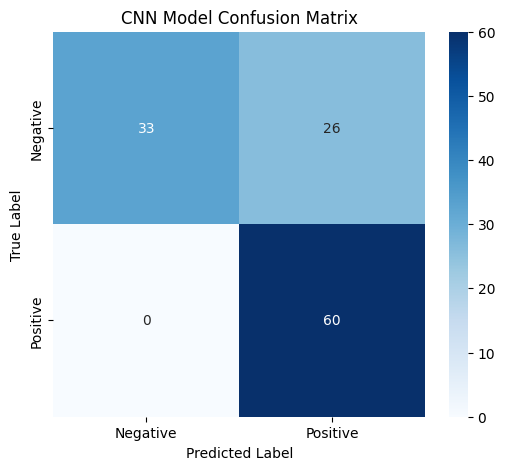

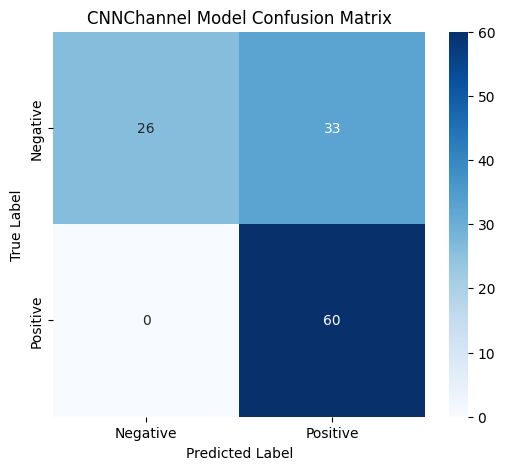

In [34]:
import seaborn as sns
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X, y, model_name):
    # Ensure input tensor has correct shape
    if X.dim() == 5:
        X = X.squeeze(1).permute(0, 3, 1, 2)  # [batch, channels, H, W]

    # Move model and input to the same device
    device = next(model.parameters()).device
    X = X.to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(X).argmax(dim=1).cpu().numpy()

    y_true = y if isinstance(y, np.ndarray) else y.cpu().numpy()

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

plot_confusion_matrix(cnn_model, valid_X_tensor, valid_y, "CNN Model")
plot_confusion_matrix(cnn_channel_model, valid_X_tensor, valid_y, "CNNChannel Model")

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"CNN Model Parameters: {count_parameters(cnn_model):,}")
print(f"CNNChannel Model Parameters: {count_parameters(cnn_channel_model):,}")

CNN Model Parameters: 206,024,962
CNNChannel Model Parameters: 207,600,642


In [36]:
import numpy as np
import torch

def show_sample_predictions(model, X, y, model_name, num_samples=5):
    # Fix input shape if needed
    if X.dim() == 5:
        X = X.squeeze(1).permute(0, 3, 1, 2)  # [batch_size, channels, height, width]

    device = next(model.parameters()).device
    X = X.to(device)
    model.eval()

    with torch.no_grad():
        y_pred = model(X).argmax(dim=1).cpu().numpy()

    # Ensure y is a NumPy array
    y_true = y if isinstance(y, np.ndarray) else y.cpu().numpy()

    print(f"\n🔍 {model_name} Sample Predictions:")
    for i in range(min(num_samples, len(y_true))):
        print(f"Example {i+1}: True Label = {y_true[i]}, Predicted Label = {y_pred[i]}")

show_sample_predictions(cnn_model, valid_X_tensor, valid_y, "CNN Model")
show_sample_predictions(cnn_channel_model, valid_X_tensor, valid_y, "CNNChannel Model")


🔍 CNN Model Sample Predictions:
Example 1: True Label = 0, Predicted Label = 0
Example 2: True Label = 1, Predicted Label = 1
Example 3: True Label = 0, Predicted Label = 0
Example 4: True Label = 1, Predicted Label = 1
Example 5: True Label = 0, Predicted Label = 0

🔍 CNNChannel Model Sample Predictions:
Example 1: True Label = 0, Predicted Label = 1
Example 2: True Label = 1, Predicted Label = 1
Example 3: True Label = 0, Predicted Label = 0
Example 4: True Label = 1, Predicted Label = 1
Example 5: True Label = 0, Predicted Label = 0
